In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){return false;}

<IPython.core.display.Javascript object>

In [3]:
from dnn_helper_functions import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [4]:
def dnn_model(X, Y, layers_dims, learning_rate = 0.0075, lambd = 0.1, num_iterations = 3000, print_cost = True):
    '''
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguements:
    X -- data, numpy array of shape (number of examples, number of features)
    Y -- true "label" vector of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size of length (number of layers + 1)
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learned by the model. They can then be used to predict.
    '''
    
    np.random.seed(1)
    costs = []
    
    #initialize parameters
    parameters = initialize_parameters_deep(layers_dims)
    
    score = 0
    c = 100
    #Loop (gradient descent)
    for i in range(0, num_iterations):
        
        #Forward Propagation: [LINEAR->RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters, layers_dims)
        
        #Compute Accuracy Score
        s = accuracy(AL,Y)
        if s > score:
            score = s
            accurate_iter = i
            
        #Compute Cost
        cost = compute_cost(AL,Y,lambd,caches)
        '''if cost < c:
            iteration = i
            c = cost
            p = parameters'''
            
        #Backward Propagation
        grads = L_model_backward(AL, Y, lambd, caches)
        
        #Update Parameters
        parameters = update_parameters(parameters, grads, learning_rate)
        
        #Print cost every 100 training examples
        if print_cost and i % 10 == 0:
            print('Cost after iteration %i: %f' %(i, cost))
        #if print_cost and i % 10 == 0:
        costs.append(cost)
    fig = plt.figure(figsize = (15,8))        
    plt.plot(np.squeeze(costs))
    plt.ylabel('Cost')
    plt.xlabel('iterations')
    plt.title('Model: '+ str(layers_dims)+' Learning rate: ' + str(learning_rate)+' Lambda: ' + str(lambd))
    #plt.text(len(costs)/2, max(costs)/2, 'Lowest cost: {:.2f} at iteration {}\n Highest Accuracy {:.2f} at iteration {}'.format(c, iteration,score,accurate_iter), fontsize = 20)
    plt.show()
   
    
    return parameters, score

In [5]:
df = pd.read_csv('XRP_Data.csv').drop(['Date', 'binned price'], axis = 1)
df[['XRP_Change','XRP_Price']] = df[['XRP_Change','XRP_Price']].shift(1)
df.at[0,['XRP_Change','XRP_Price']] = [9.57, 0.1786]

In [7]:
df.XRP_Price.describe()

count    253.000000
mean       0.619210
std        0.571493
min        0.152500
25%        0.205700
50%        0.258300
75%        0.903880
max        2.770000
Name: XRP_Price, dtype: float64

In [129]:
def make_xy(df, cuts = 50, one_hots = True):
    
    y = df.XRP_Price.shift(-1)[:-1]
    X = df.iloc[:-1,:]
    
    xscaler = MinMaxScaler()
    xscaler.fit(X)
    

    
    def one_hot(y, cuts = 50):
        data, bins = pd.cut(y, retbins = True, bins = cuts, labels = range(cuts))
        y = np.zeros((len(y),cuts))

        for pos in range(len(y)):
            y[pos, data[pos]] = 1
        return y, data, bins
    
    
    
    X = xscaler.transform(X)
    
    
    if one_hots:
        
        y, data, bins = one_hot(y, cuts = cuts)
        return X, y, data, bins
    
    else:
        yscaler = MinMaxScaler()
        y = y.values.reshape(-1,1)
        yscaler.fit(y)
        y = yscaler.transform(y)
        return X, y, xscaler, yscaler

In [139]:
X, y, xscaler, yscaler = make_xy(df, cuts = 10, one_hots = True)

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.95, random_state = 4)

/home/scott/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [132]:
X = X_train.T

Y = y_train.reshape(y_train.shape[1],y_train.shape[0])
print(X.shape,Y.shape)

(29, 239) (10, 239)


In [133]:
'''X = X_train.T
X_T = X_test.T
Y = y_train.reshape(1, y_train.shape[0])
Y_T = y_test.reshape(1, y_test.shape[0])'''

'X = X_train.T\nX_T = X_test.T\nY = y_train.reshape(1, y_train.shape[0])\nY_T = y_test.reshape(1, y_test.shape[0])'

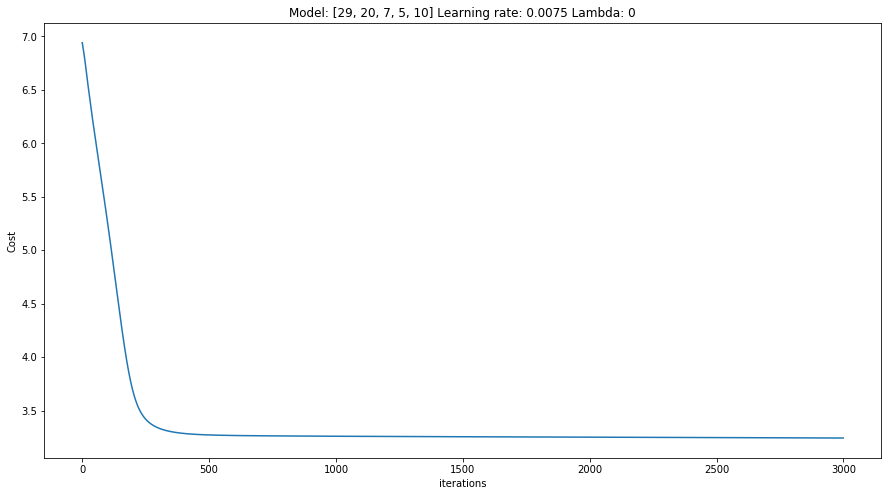

In [134]:
parameters = dnn_model(X,Y, layers_dims = [29, 20, 7, 5, 10], learning_rate = 0.0075, lambd = 0,num_iterations=3000, print_cost = False)

In [135]:
AL, _ = L_model_forward(X, parameters,layer_dims = [29, 20, 7, 5, 10])

In [136]:
maxis =[]
ymaxis = []
for a in AL.T:
    maxis.append(a.argmax())
    
for a in Y.T:
    ymaxis.append(a.argmax())

assert(len(maxis) == len(ymaxis))
data = {'pred':maxis, 'true':ymaxis}
f = pd.DataFrame(data, index = range(len(maxis)))
f['score'] = np.abs(f.pred - f.true)
score = len(f[f.score == 0]) / len(f)
score

0.06694560669456066

In [ ]:
Y.T[4].argmax()

In [ ]:
df1 = pd.DataFrame({'Y_pred':np.squeeze(AL.T), 'Y_true':np.squeeze(y_train.T)}, index = range(len(AL.T)))
df1['Error'] = df1.Y_true - df1.Y_pred
df1.Error.max()

In [ ]:
ax = df1[['Y_pred','Y_true']].plot(figsize = (15,9), color = ['k', 'b'], ls = '--')
#ax.fill_between(df1.index, np.zeros(len(df1)), df1.Y_true, color = 'purple', alpha = 0.4)
df1.Error.plot(legend = True, color = 'k', ls = '--')
plt.show()

In [ ]:
ALT, _ = L_model_forward(X_T, parameters, layer_dims = [29,20,7,5,1])
'''size = len(_)
reg = 0
for i in range(size):
    linear_cache , activation_cache = _[i]
    a,w,b = linear_cache
    reg += np.sum(w**2)

    
reg'''
len(_)

In [ ]:
df2 = pd.DataFrame({'Y_pred':np.squeeze(ALT.T), 'Y_true':np.squeeze(y_test.T)}, index = range(len(ALT.T)))
df2['Error'] = df2.Y_true - df2.Y_pred
df2.Error.max()

In [ ]:
ax = df2[['Y_pred', 'Y_true']].plot(figsize = (15,9))
df2.Error.plot(legend = True, color = 'k', ls = '--')
plt.show()

In [ ]:
AL[3].argmax()

In [147]:
def run_model(X, y, layers_dims = [29,20,7,5,10]):
    data = {}
    #Training set size [0.05 - 0.95] in increments of 0.05
    for i in [0.05*x for x in range(1, 20, 2)]:
        #Split data into Training and Test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = i, random_state = 4)
        
        #Reshape data to proper shape
        X_train = X_train.T
        X_test = X_test.T
        Y_train = y_train.reshape(y_train.shape[1], y_train.shape[0])
        Y_test = y_test.reshape(y_train.shape[1], y_test.shape[0])
        
        #Train NN and score
        print('Training Set Size: ', len(X_train.T))
        parameters, score = dnn_model(X_train,Y_train, layers_dims = layers_dims, num_iterations=100, print_cost = False)
        
        #Score the test set
        AL, _ = L_model_forward(X_test, parameters,layer_dims = layers_dims)
        s = accuracy(AL,y_test)
        
        
        data['Training_Size_'+str(i)] = len(X_train.T)
        data['Training_Score_'+str(i)] = score
        data['Test_score_'+str(i)] = s

    return data
       

/home/scott/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Training Set Size:  12


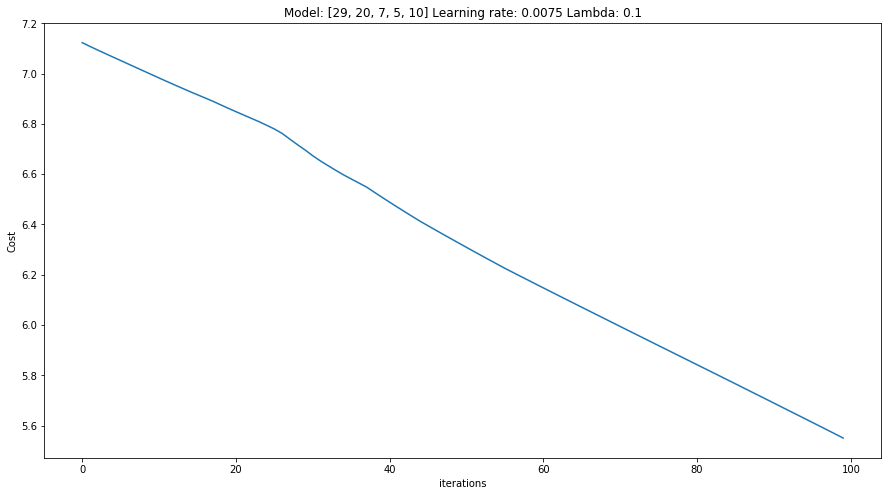

ValueError: could not broadcast input array from shape (10) into shape (240)

In [148]:
run_model(X, y)

In [11]:
pd.cut(df.XRP_Price, bins = 3, labels = range(3), retbins = True)

(0      0
 1      0
 2      0
 3      0
 4      0
 5      0
 6      0
 7      0
 8      0
 9      0
 10     0
 11     0
 12     0
 13     0
 14     0
 15     0
 16     0
 17     0
 18     0
 19     0
 20     0
 21     0
 22     0
 23     0
 24     0
 25     0
 26     0
 27     0
 28     0
 29     0
       ..
 223    0
 224    0
 225    0
 226    0
 227    0
 228    0
 229    0
 230    0
 231    0
 232    0
 233    0
 234    0
 235    0
 236    0
 237    0
 238    0
 239    0
 240    0
 241    0
 242    0
 243    0
 244    0
 245    0
 246    0
 247    0
 248    0
 249    0
 250    0
 251    0
 252    0
 Name: XRP_Price, Length: 253, dtype: category
 Categories (3, int64): [0 < 1 < 2],
 array([0.1498825, 1.025    , 1.8975   , 2.77     ]))